In [30]:
from preprocessing import extract_events, create_raw
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import mne
from scipy.stats import ttest_ind, ttest_ind_from_stats
import matplotlib.gridspec as gridspec

In [44]:
# List of dataframes
recordings = [pd.read_pickle(f) for f in os.listdir('.') if f.endswith('.pkl')]

# settings
event_id = dict(call=1, no_call=2, not_bluffing=3, bluffing=4)
tmin, tmax = -4, 4

epochs = mne.Epochs(create_raw(recordings[4]),
                    events=extract_events(np.array(recordings[4]['event_stream'])),
                    event_id=event_id, tmin=tmin, tmax=tmax, preload=True)

Creating RawArray with float64 data, n_channels=10, n_times=8793
    Range : 0 ... 8792 =      0.000 ...   879.200 secs
Ready.
88 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 88 events and 81 original time points ...
0 bad epochs dropped


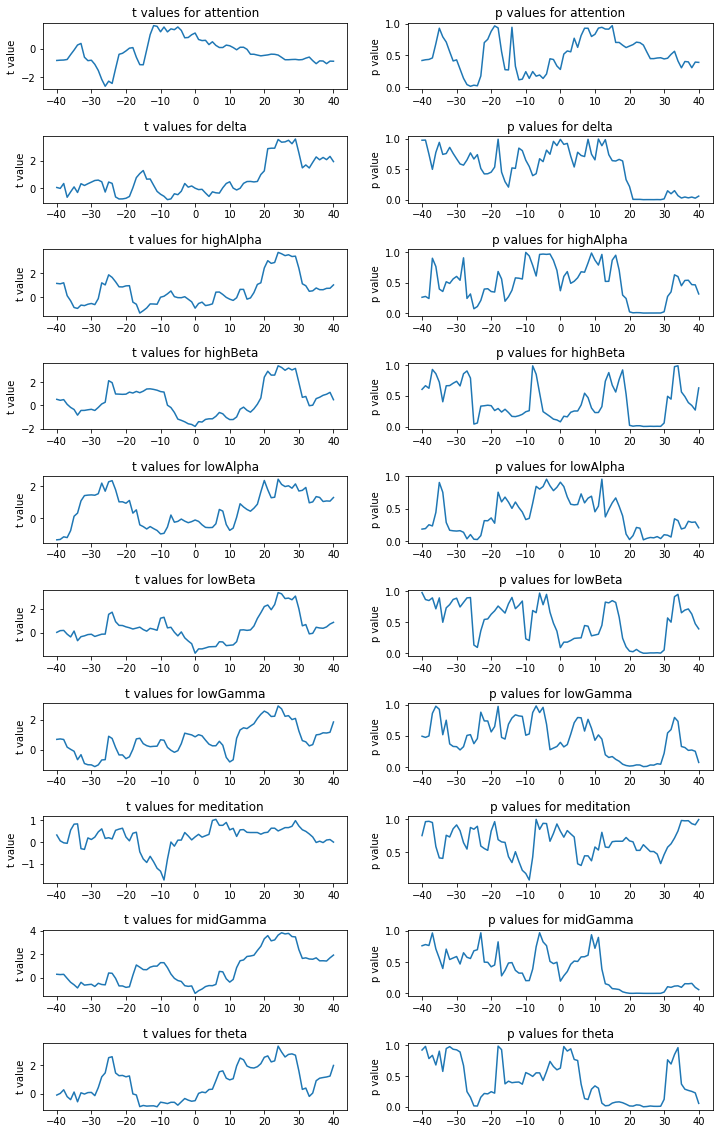

In [50]:
fig = plt.figure(figsize=[12, 20])
fig.subplots_adjust(hspace=.7)
gs = gridspec.GridSpec(len(epochs.ch_names), 2, figure=fig)
data={}

#step through the channel names, eg attention, delta, highAlpha...
for i, ch_name in enumerate(epochs.ch_names):
    #a is bluffing at the specific channel name. 
    #.T is used to rotate the array for the time series to be up front
    a=epochs['bluffing'].copy().pick_channels(ch_names=[ch_name])._data.T
    #b is not bluffing at the specific channel name. 
    b=epochs['not_bluffing'].copy().pick_channels(ch_names=[ch_name])._data.T
    l=len(a)#number of time values we have basically its (tmax-tmin)*10
    
    t_values=[]
    p_values=[]
    #loop through all time values 
    for t in range(l):
        #preform tests
        t, p = ttest_ind(a[t][0], b[t][0])

        t_values.append(t)
        p_values.append(p)
        
    #The data is saved in this dictionary for future use eg data['attention']['t_values']
    data[ch_name]={'t_values':t_values, 'p_values':p_values}
    
    #plot t values
    ax1=fig.add_subplot(gs[i, 0], label=ch_name)
    ax1.set_ylabel('t value')
    ax1.set_title('t values for %s' % ch_name)
    ax1.plot(np.arange(len(t_values))-(tmax*10), t_values)
    
    #plot p values
    ax2=fig.add_subplot(gs[i, 1], label=ch_name)
    ax2.set_ylabel('p value')
    ax2.set_title('p values for %s' % ch_name)
    ax2.plot(np.arange(len(p_values))-(tmax*10), p_values)
